In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Import Datasets

In [2]:
train1 = pd.read_csv('data/xav_train1.csv')
train2 = pd.read_csv('data/xav_train2.csv')
train3 = pd.read_csv('data/xav_train3.csv')
train4 = pd.read_csv('data/xav_test1.csv')
test1 = pd.read_csv('data/Joel.csv')

# Cleaner Function

In [3]:
def data_cleaner(df):
    # create 2 copies to reshape the data
    df1 = df.copy()
    df2 = df.copy()

    # drop interval column in df1, key hold duration in df2
    df1.drop(['interval'], axis=1, inplace=True)
    df1.drop(['key_hold_duration'], axis=1, inplace=True)
    df2.drop(['key_hold_duration'], axis=1, inplace=True)

    # drop first row in df1 and last row in df2
    df1 = df1.drop(df1.index[-1]).reset_index(drop=True)
    df2 = df2.drop(df2.index[0]).reset_index(drop=True)

    # rename the columns 
    df1.columns = ['word1']
    df2.columns = ['word2', 'interval']

    # change interval to integer
    df2['interval'] = abs(df2['interval'].astype(int))

    # merge the two dataframes
    df3 = pd.merge(df1, df2, left_index=True, right_index=True)
    df3['word_combo'] = df3['word1'].astype(str) + ',' + df3['word2'].astype(str)
    df3.drop(['word1', 'word2'], axis=1, inplace=True)
    df4 = df3.copy()

    # if multiple of same word combo exists take the average interval
    df4 = df4.groupby('word_combo').mean().reset_index()

    return df4

# Clean All Data

In [4]:
# clean all datasets
final_train1 = data_cleaner(train1)
final_train2 = data_cleaner(train2)
final_train3 = data_cleaner(train3)
final_train4 = data_cleaner(train4)
final_test = data_cleaner(test1)

In [5]:
# combine all training data
# final_train = pd.concat([final_train1, final_train2, final_train3], ignore_index=True)
final_train = pd.concat([final_train1, final_train2, final_train3, final_train4], ignore_index=True)
final_train = final_train.groupby('word_combo').mean().reset_index()

display(final_train)

,word_combo,interval
0,"186,8",438.000000
1,"186,84",70.000000
2,"188,188",43.500000
3,"188,32",114.450000
4,"188,8",267.166667
...,...,...
326,"89,190",78.000000
327,"89,32",80.875000
328,"89,68",217.500000
329,"89,72",147.500000


In [6]:
# combine all test data
# final_test = pd.concat([final_test1, final_test2], ignore_index=True)
# final_test = final_test.groupby('word_combo').mean().reset_index()
display(final_test)

,word_combo,interval
0,"186,8",397.000000
1,"188,32",317.500000
2,"188,8",568.000000
3,"190,32",342.285714
4,"222,84",186.500000
...,...,...
201,"87,72",383.000000
202,"87,73",114.000000
203,"87,76",81.000000
204,"89,32",162.666667


# Cluster Data

In [7]:
kmeans_train = KMeans(n_clusters=3, random_state=0).fit(final_train[['interval']])
final_train['cluster'] = kmeans_train.labels_
train_centroids = kmeans_train.cluster_centers_

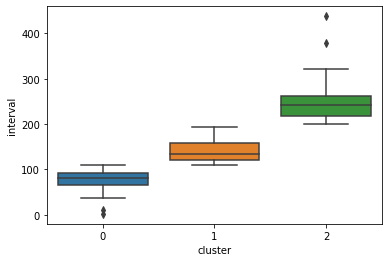

In [8]:
# boxplot with clusters
sns.boxplot(x='cluster', y='interval', data=final_train)
plt.show()

In [9]:
kmeans_test = KMeans(n_clusters=3, random_state=0, init=train_centroids).fit(final_test[['interval']])
final_test['cluster'] = kmeans_test.labels_
train_centroids = kmeans_test.cluster_centers_

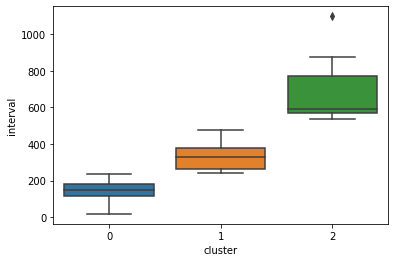

In [10]:
# boxplot with clusters
sns.boxplot(x='cluster', y='interval', data=final_test)
plt.show()

In [11]:
# innerjoin the two datasets
final = pd.merge(final_train, final_test, on='word_combo', how='inner')
display(final)

,word_combo,interval_x,cluster_x,interval_y,cluster_y
0,"186,8",438.000000,2,397.000000,1
1,"188,32",114.450000,1,317.500000,1
2,"188,8",267.166667,2,568.000000,2
3,"190,32",112.285714,1,342.285714,1
4,"222,84",109.000000,0,186.500000,0
...,...,...,...,...,...
168,"87,65",58.833333,0,328.000000,1
169,"87,69",90.250000,0,590.000000,2
170,"87,72",126.250000,1,383.000000,1
171,"87,73",78.666667,0,114.000000,0


# Accuracy

In [12]:
correct = 0
for i in range(len(final)):
    if final['cluster_x'][i] == final['cluster_y'][i]:
        correct += 1

correct / len(final)

0.5549132947976878